In [1]:
import csv
import PIL
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import ConnectionPatch
import heapq

In [2]:
#determining corners of patches
def computeImgPatchCornerIndices(widthIndex,heightIndex,patchSize):
    imgPatchCornerIndices=[] #designationFirstImg (i,j), firstCorner(x,y), secondCorner(x,y)
    for i in range (0,widthIndex):
        for j in range (0,heightIndex):
            imgPatchCornerIndices.append([i*patchSize,j*patchSize,patchSize*(i+1)-1,patchSize*(j+1)-1])
    return(imgPatchCornerIndices)

In [3]:
#here find corner of patches in the second img which is transferred by H
def computeImgPatchCornerIndicesSecondImg (cornersReferenceImgPatches,H):
    cornersSecondImgPatches = []
    for i in range (0,len(cornersReferenceImgPatches)):
        corner1Homoform=np.array([[cornersReferenceImgPatches[i][0]],[cornersReferenceImgPatches[i][1]],[1]])
        corner2Homoform=np.array([[cornersReferenceImgPatches[i][2]],[cornersReferenceImgPatches[i][3]],[1]])
    
        t1 = np.matmul(H,corner1Homoform)
        t2 = np.matmul(H,corner2Homoform)
        
        x1=float(t1[0][0]/t1[2][0])
        y1=float(t1[1][0]/t1[2][0])
        x2=float(t2[0][0]/t2[2][0])
        y2=float(t2[1][0]/t2[2][0])
        
        cornersSecondImgPatches.append([x1,y1,x2,y2])
    
    return(cornersSecondImgPatches)

In [4]:
#now classify keypoints to the patches they belong to
def classifyPointstoPatches(keyPointsList, patchIndices):
    pointsInPatches=[]
    for i in range(0,len(keyPointsList)):
        for j in range(0,len(patchIndices)):
            if ( (patchIndices[j][0] <= keyPointsList[i][1]) and (keyPointsList[i][1] <= patchIndices[j][2])
            and (patchIndices[j][1] <= keyPointsList[i][0]) and (keyPointsList[i][0] <= patchIndices[j][3]) ):
                #print('point ',i, ' belongs to patch', j )
                pointsInPatches.append([i,j])
                break
            #else:
    return(pointsInPatches)

In [21]:
#comparing distance between two classified sets of keypoints
def compareKeypointsByDescriptors(descriptor_1,descriptor_2):
    %matplotlib inline  
    fig = plt.figure(figsize=(50,50))#you can add figsize(x,y) to control the display size of the photo
    print(len(descriptor_1), len(descriptor_2))#, len(pointsInPatches1), len(pointsInPatches2))
    
    if ( len(descriptor_1)<=len(descriptor_2) ):#which list is shorter, make it ref
        #shortlist = pointsInPatches1
        shortlist_Descriptors = descriptor_1
        #longlist = pointsInPatches2
        longlist_Descriptors = descriptor_2
        
        img = mpimg.imread('/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/1.ppm')
        ax1=fig.add_subplot(121)
        plt.imshow(img)

        img = mpimg.imread('/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/2.ppm')
        ax2=fig.add_subplot(122)
        plt.imshow(img)
    else:
        #shortlist = pointsInPatches2
        shortlist_Descriptors = descriptor_2
        #longlist = pointsInPatches1
        longlist_Descriptors = descriptor_1
        
        img = mpimg.imread('/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/2.ppm')
        ax1=fig.add_subplot(121)
        plt.imshow(img)

        img = mpimg.imread('/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/1.ppm')
        ax2=fig.add_subplot(122)
        plt.imshow(img)
    
    for i in range(0,len(longlist_Descriptors)):
        longlist_matched[i]=[False]
    
    totalDistance = 0
    acceptedPairs=[]
    for i in range (0,len(shortlist_Descriptors):#(0,len(shortlist_Descriptors))
        potentialPairforPointi=[]
        #currentPatchNumber = shortlist[i][1]
        for j in range (0,len(longlist_Descriptors)):
            patchNumberToCompareWith = longlist[j][1]
            if ( currentPatchNumber == patchNumberToCompareWith ) and (not longlist[j][2]):
                #find distance
                x=[shortlist_Keypoints[i][0],shortlist_Keypoints[i][1]]
                y=[longlist_Keypoints[j][0],longlist_Keypoints[j][1]]
                distance = np.sqrt(np.dot(x,y))
                #distance = math.sqrt( (shortlist_Keypoints[i][0] - longlist_Keypoints[j][0])**2 + 
                #(shortlist_Keypoints[i][1] - longlist_Keypoints[j][1])**2 )
                potentialPairforPointi.append((distance,j))
        max_2=heapq.nlargest(2,potentialPairforPointi)
        if (len(max_2)==0):{}
            #print('here is 0',len(max_2))
        elif (len(max_2)==1):
            #print('here is 1',len(max_2))
            acceptedPairs.append((i,max_2[0][1], max_2[0][0]))
            longlist[max_2[0][1]][2]=True
        else:
            #print('here is 2',len(max_2))
            if(max_2[1][0]/(max_2[0][0]+0.00001)<=0.5):
                #accepted pair(i from short list, j from long list, distance)
                acceptedPairs.append((i,max_2[0][1], max_2[0][0]))
                longlist[max_2[0][1]][2]=True
    
    #now drawing accepted pairs
    print(len(acceptedPairs))
    for i in range(0,len(acceptedPairs)):
        pointInFirstImg=(shortlist_Keypoints[acceptedPairs[i][0]][1],shortlist_Keypoints[acceptedPairs[i][0]][0]) #first point
        pointInSecondImg=(longlist_Keypoints[acceptedPairs[i][1]][1],longlist_Keypoints[acceptedPairs[i][1]][0]) #second point
        con = ConnectionPatch(xyA=pointInSecondImg, xyB=pointInFirstImg, coordsA="data", 
            coordsB="data", axesA=ax2, axesB=ax1, color="red")

        ax2.add_artist(con)

        ax1.plot(shortlist_Keypoints[acceptedPairs[i][0]][1],shortlist_Keypoints[acceptedPairs[i][0]][0],
                 'r',markersize=20, marker='s', fillstyle="none")
        #(optional)put a mark on the first image
        ax2.plot(longlist_Keypoints[acceptedPairs[i][1]][1],longlist_Keypoints[acceptedPairs[i][1]][0],
                 'r',markersize=20, marker='s', fillstyle="none")
        #(optional)put a mark on the second image

1210
907
747 720 747 623
17


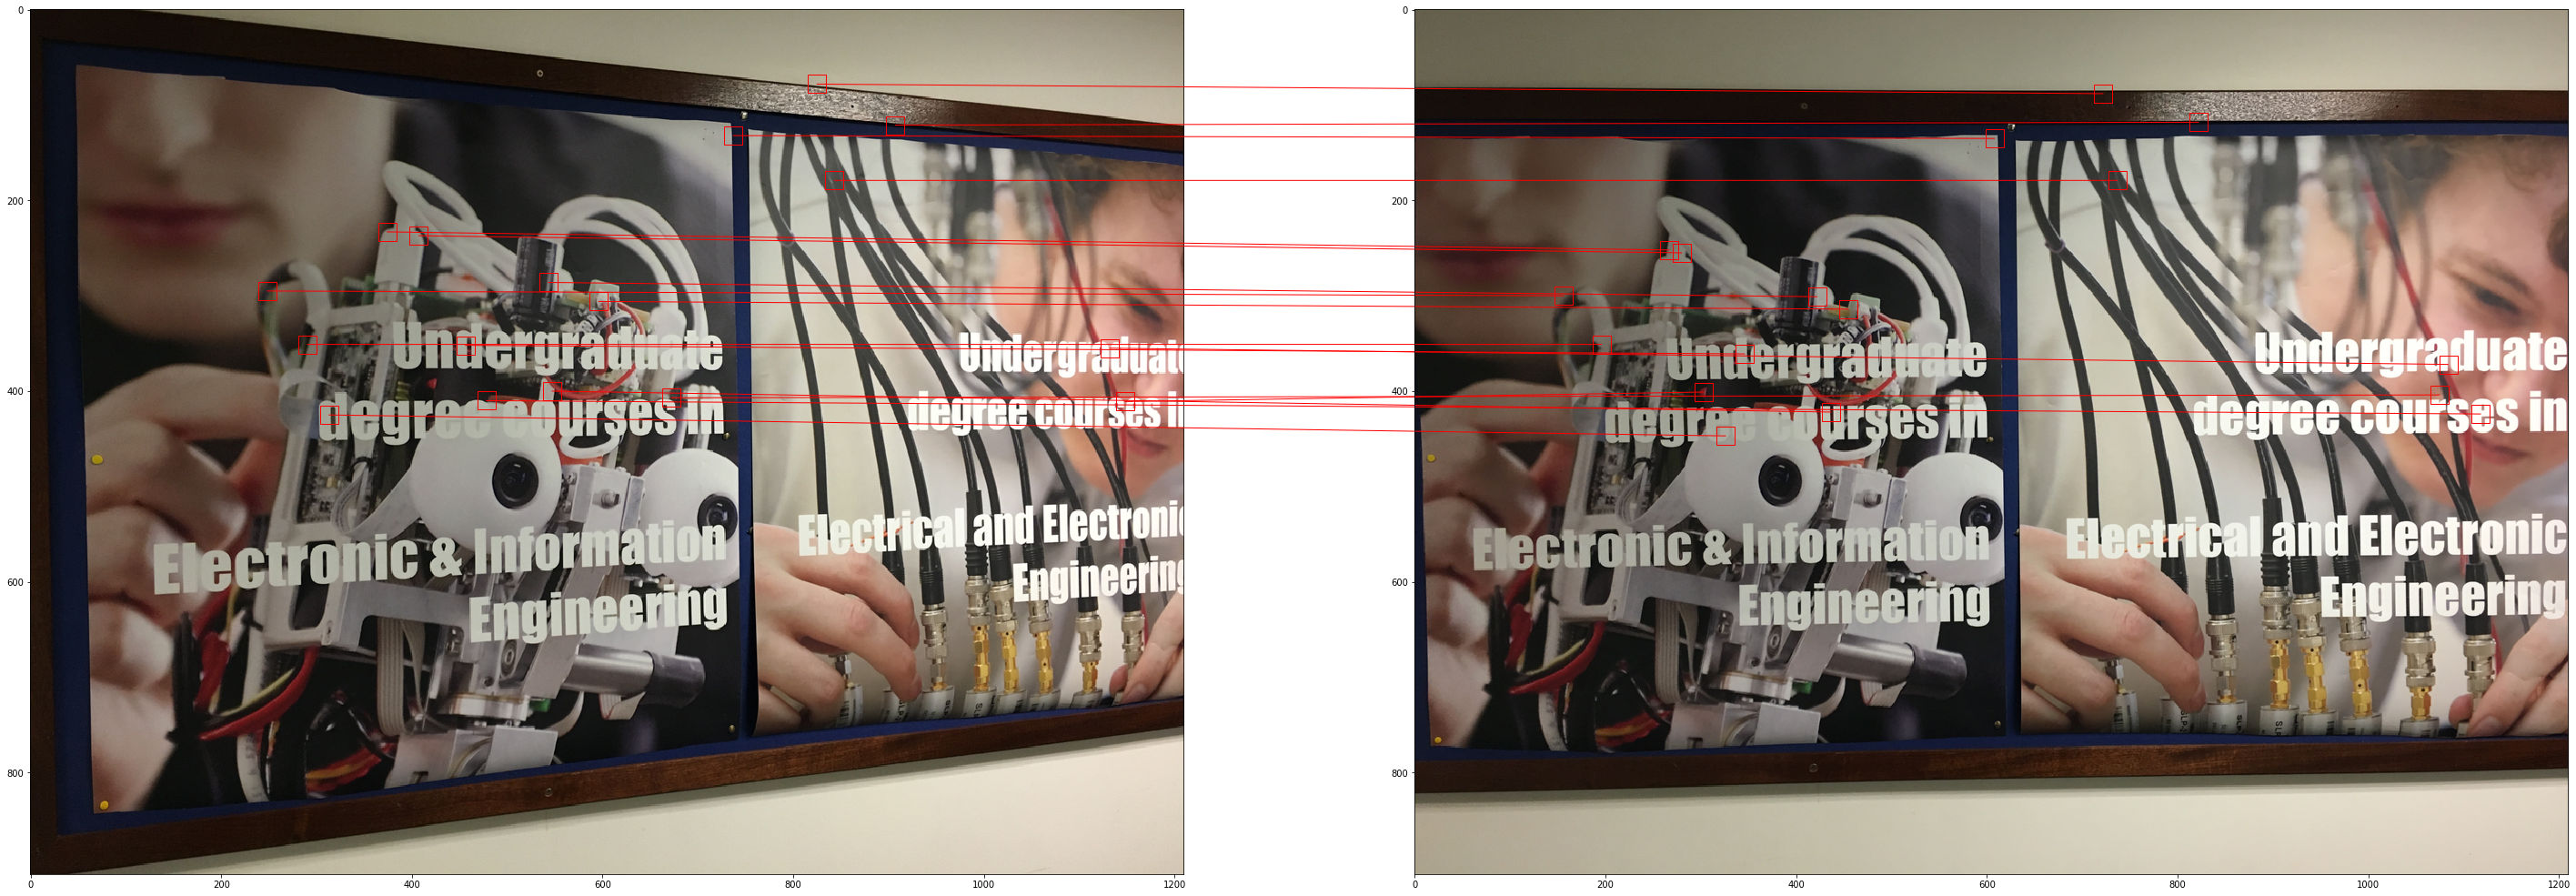

In [22]:
descriptor_1=[]
with open('/home/sherif/workspace/pythonCode/courses1/oct_2_descriptorData.csv', 'r' ) as fp2:
    reader=csv.reader(fp2, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    count = 0
    for row in reader:
        #print(row)
        descriptor_1.append(row)
        
descriptor_2=[]
with open('/home/sherif/workspace/pythonCode/courses2/oct_2_descriptorData.csv', 'r' ) as fp2:
    reader=csv.reader(fp2, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    count = 0
    for row in reader:
        #print(row)
        descriptor_2.append(row)

image = PIL.Image.open("/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/1.ppm")
width, height = image.size
print(width) #this is the second number in the data read from the file
print(height) #this is the first number in the data read from the file

patchSize = 25

widthIndex = int(width/patchSize)
heightIndex = int(height/patchSize)
#cornersReferenceImgPatches=computeImgPatchCornerIndices(widthIndex,heightIndex,patchSize)
#H =np.array([[1,0,0],[0,1,0],[0,0,1]])
#H =np.array([[1.3587,-0.005952,52.219],[0.14127,1.2223,-104.69],[0.00032175,-7.4735e-06,0.99967]])
#cornersSecondImgPatches=computeImgPatchCornerIndicesSecondImg(cornersReferenceImgPatches,H)

#print(len(keyPoints_2))
#pointsInPatches1=classifyPointstoPatches(keyPoints_1, cornersReferenceImgPatches)
#pointsInPatches2=classifyPointstoPatches(keyPoints_2, cornersSecondImgPatches)
#print(len(pointsInPatches2))

compareKeypointsByDescriptors(descriptor_1,descriptor_2)#,pointsInPatches1,pointsInPatches2)

In [23]:
#print(len(cornersReferenceImgPatches))
#print(len(cornersSecondImgPatches))

#print(cornersSecondImgPatches)
#print(cornersReferenceImgPatches)
#classifyPointstoPatches(keyPoints_2, cornersSecondImgPatches)

#H =np.array([[1,0,0],[0,1,0],[0,0,1]])
#print(H)
#b = np.array([2.3,2.4,2.5])
#print(b)
#x = np.matmul(b,H)
#print(x[0])
min(4,3)

3

In [24]:
a = [[2,3],[4,6],[50,50]]

a[0] = a[0]+[True]
print(len(a))
print(a[0][2])

b=True
c=not b
print

3
True


<function print>

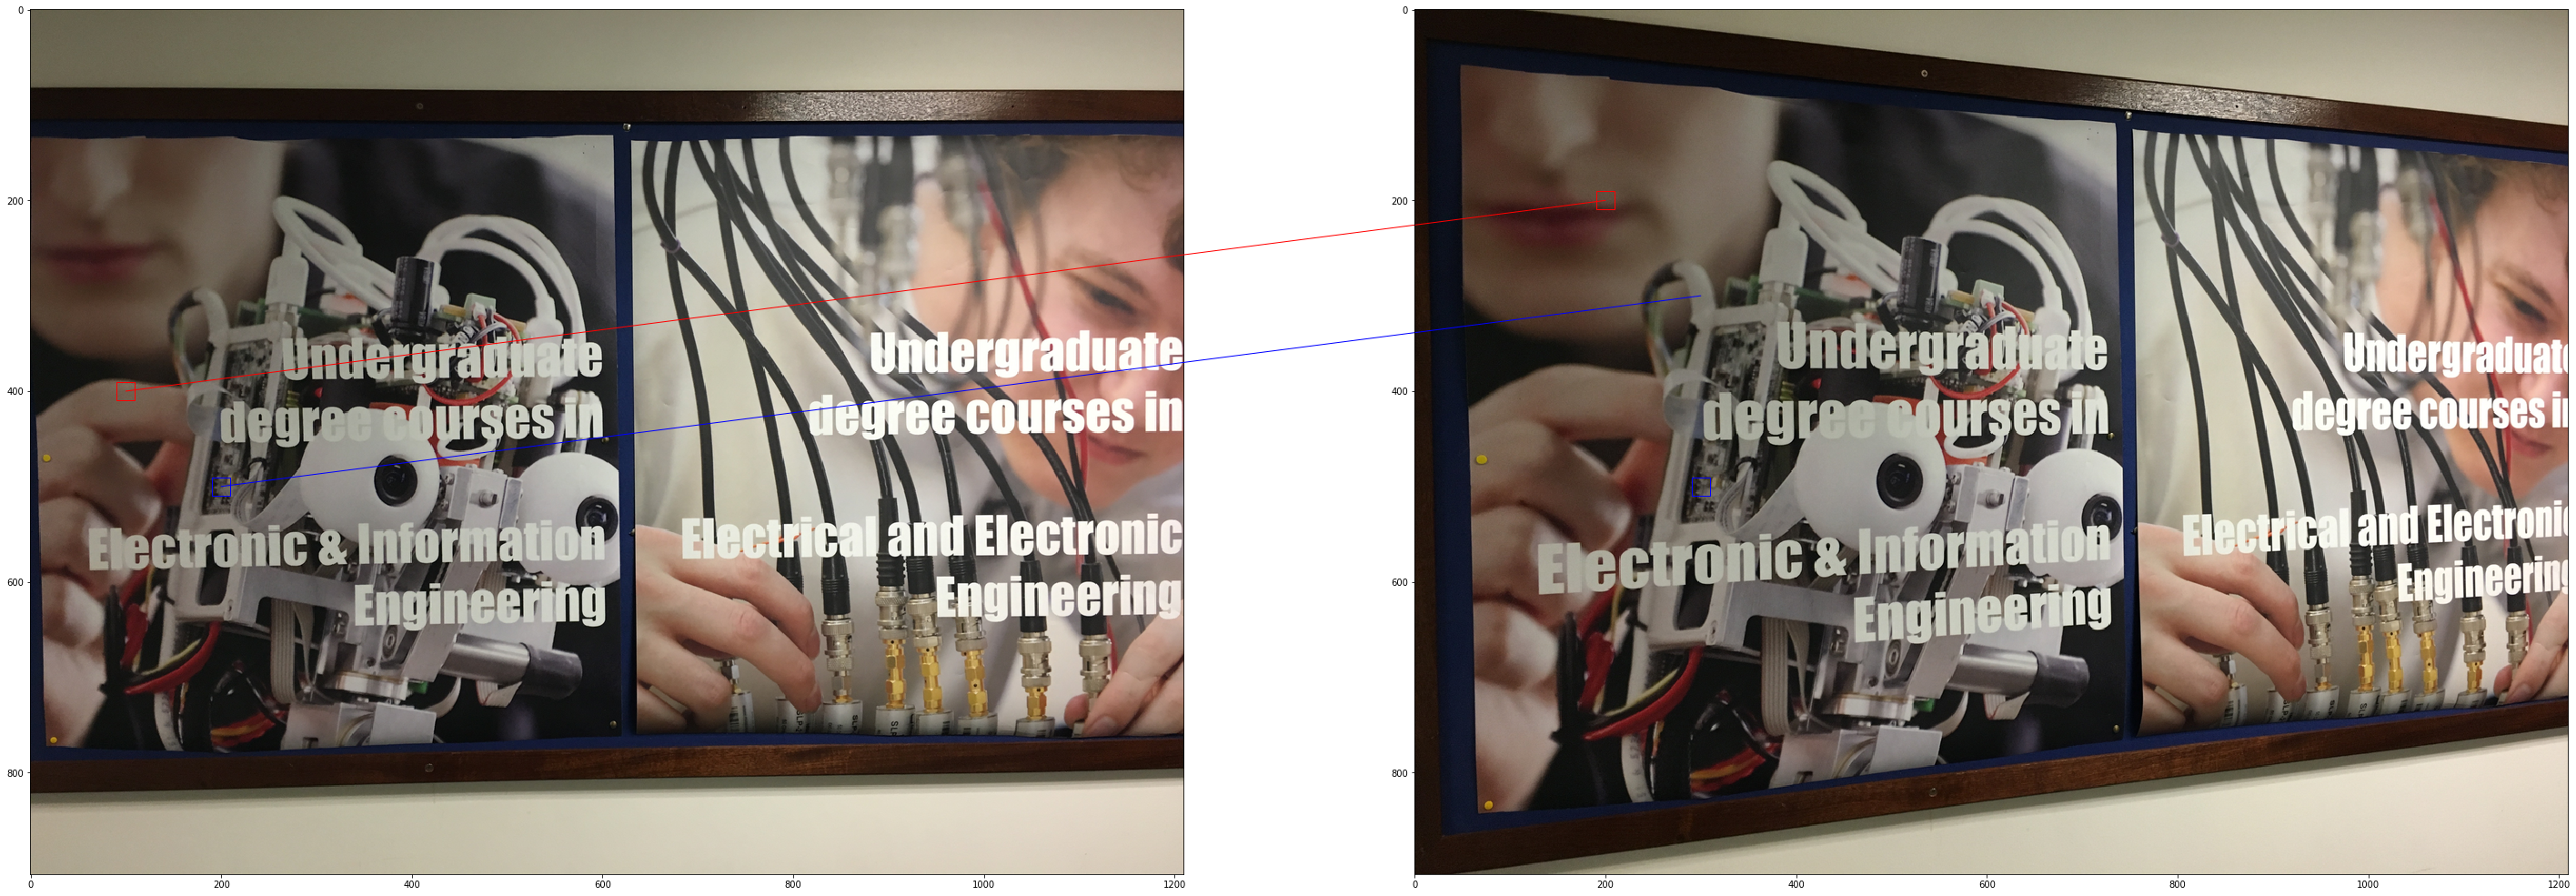

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import ConnectionPatch

%matplotlib inline  
fig = plt.figure(figsize=(50,50))#you can add figsize(x,y) to control the display size of the photo

img = mpimg.imread('/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/1.ppm')
ax1=fig.add_subplot(121)
plt.imshow(img)

img = mpimg.imread('/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/2.ppm')
ax2=fig.add_subplot(122)
plt.imshow(img)

#ax1.plot(200,200,'ro')
#ax2.plot(200,200,'ro')

pointInFirstImg=(100,400) #first point
pointInSecondImg=(200,200) #second point
con = ConnectionPatch(xyA=pointInSecondImg, xyB=pointInFirstImg, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color="red")

ax2.add_artist(con)

ax1.plot(100,400,'r',markersize=20, marker='s', fillstyle="none")#(optional)put a mark on the first image
ax2.plot(200,200,'r',markersize=20, marker='s', fillstyle="none")#(optional)put a mark on the second image


pointInFirstImg=(200,500) #first point
pointInSecondImg=(300,300) #second point
con = ConnectionPatch(xyA=pointInSecondImg, xyB=pointInFirstImg, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color="blue")

ax2.add_artist(con)

ax1.plot(200,500,'b',markersize=20, marker='s', fillstyle="none")#(optional)put a mark on the first image
ax2.plot(300,500,'b',markersize=20, marker='s', fillstyle="none")#(optional)put a mark on the second image



plt.show()

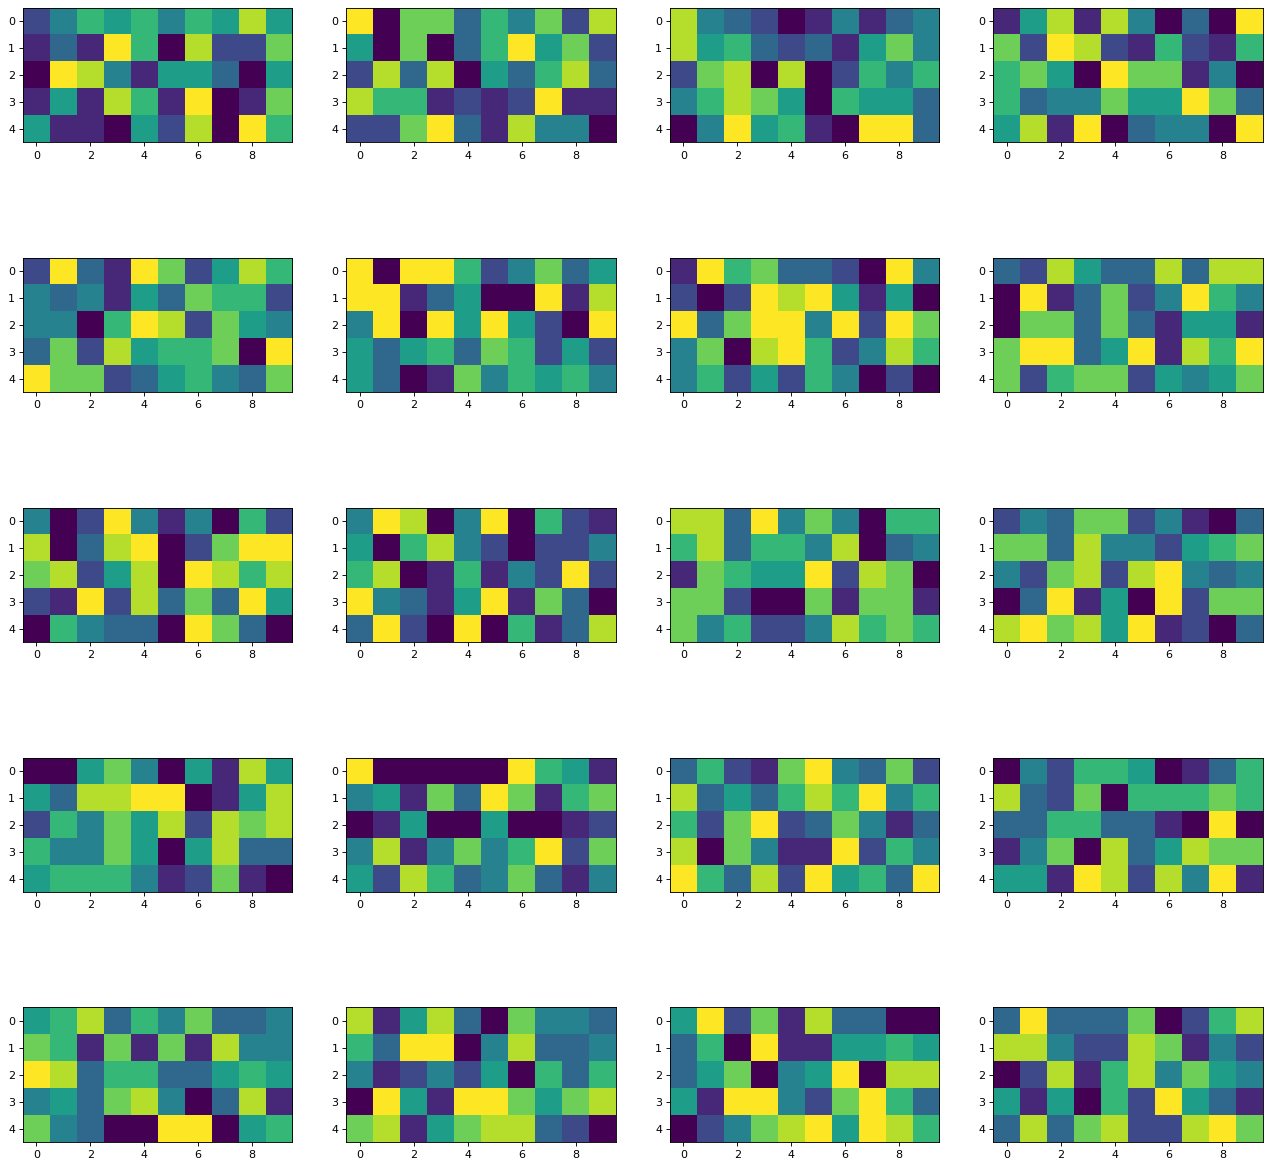

In [26]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=5
fig=plt.figure(figsize=(20, 20), dpi=80)
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [27]:
import heapq
xy=[(10,300)]
print(xy[0])

list=[(3,4),(5,6)]
print(list[0][1])
#xy.append((4000,4000))
print(xy)
max_2=heapq.nlargest(2,xy)
print(max_2)
#print(max_2[0][0])
x=10
y=10
if (x==50):{}
    
elif (x==10):
    print(2)
else:
    print(3)

(10, 300)
4
[(10, 300)]
[(10, 300)]
2


In [28]:
print(H)
x=[3,4]
y=[2,1]
z=np.sqrt(np.dot(x,y))
print(z)

[[ 1.3587e+00 -5.9520e-03  5.2219e+01]
 [ 1.4127e-01  1.2223e+00 -1.0469e+02]
 [ 3.2175e-04 -7.4735e-06  9.9967e-01]]
3.1622776601683795
